# DCGAN for generating MNIST-like data
#### Original DCGAN paper: https://arxiv.org/pdf/1511.06434
#### Inspired by: https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/
#### Zach D.

In [ ]:
%config IPCompleter.greedy=True
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

## Defining the Network
### Generator

In [9]:
def generator():
    net = tf.keras.Sequential()
    
    net.add(tf.keras.layers.Dense(4*4*1024,
                                    input_shape=(100,)))
    net.add(tf.keras.layers.Reshape(target_shape=(4,4,1024)))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.Activation('relu'))
              
    net.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(5,5),
                                              strides=(2,2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.Activation('relu'))
              
    net.add(tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(5,5),
                                              strides=(2,2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.Activation('relu'))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5),
                                              strides=(2,2), padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.Activation('relu'))
    
    net.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5),
                                              strides=(2,2), padding='same'))
    net.add(tf.keras.layers.Activation('tanh'))
    
    return net
    

### Discriminator

In [10]:
def discriminator():
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Conv2D(filters=64, 
                                     strides=(2, 2),
                                     kernel_size=(5, 5),
                                     input_shape=(64,64,1),
                                     padding='same'))
    net.add(tf.keras.layers.LeakyReLU(0.2))
    
    net.add(tf.keras.layers.Conv2D(filters=128, 
                                     strides=(2, 2),
                                     kernel_size=(5, 5),
                                     padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.LeakyReLU(0.2))
    
    net.add(tf.keras.layers.Conv2D(filters=256, 
                                     strides=(2, 2),
                                     kernel_size=(5, 5),
                                     padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.LeakyReLU(0.2))
    
    net.add(tf.keras.layers.Conv2D(filters=512, 
                                     strides=(2, 2),
                                     kernel_size=(5, 5),
                                     padding='same'))
    net.add(tf.keras.layers.BatchNormalization(momentum=0.5))
    net.add(tf.keras.layers.LeakyReLU(0.2))
    
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(1))
    net.add(tf.keras.layers.Activation('sigmoid'))
    
    return net

### Adversarial Network (G + D)

In [33]:
net_discriminator=discriminator()
net_generator=generator()

optim_discriminator = tf.keras.optimizers.RMSprop(lr=0.00008, decay=1e-10)
model_discriminator = tf.keras.Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

optim_adversarial = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-10)
model_adversarial = tf.keras.Sequential()
model_adversarial.add(net_generator)

for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])
model_adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 64, 64, 1)         18869761  
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 4315137   
Total params: 23,184,898
Trainable params: 18,865,921
Non-trainable params: 4,318,977
_________________________________________________________________


## Visualize and load the real data

In [19]:
(x_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()
print(x_train[1].shape)
batch_size = 64

(28, 28)


In [20]:
def preprocess_fn(image, label):
    x = tf.reshape(tf.cast(image, tf.float32), (28,28,1))
    x = tf.image.resize_images(x, (64,64))
    x = tf.reshape(tf.cast(x, tf.float32), (64,64,1))
    x /= 255.0
    y = tf.one_hot(label, 10)
    return x,y
mnist_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
mnist_ds = mnist_ds.shuffle(10000)
mnist_ds = mnist_ds.apply(tf.data.experimental.map_and_batch(
        preprocess_fn, batch_size=batch_size, num_parallel_batches=6, 
        drop_remainder=True))
# real_ds = real_ds.map(real_ds_preprocess_fn)
mnist_ds = mnist_ds.repeat()
mnist_ds = mnist_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [60]:
batch_size = 64

## Create fake data and train network

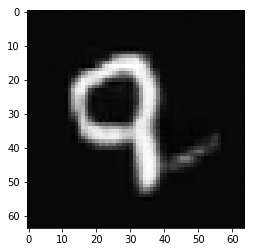

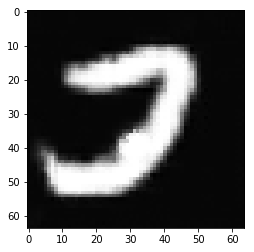

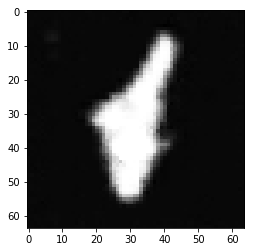

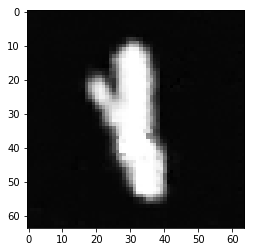

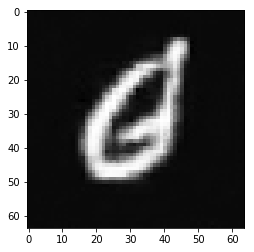

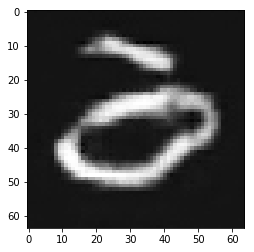

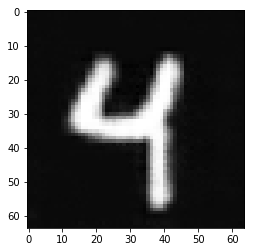

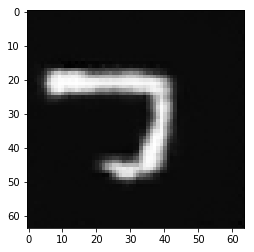

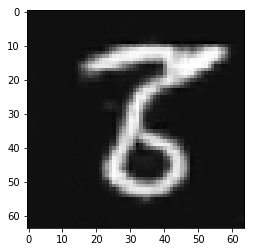

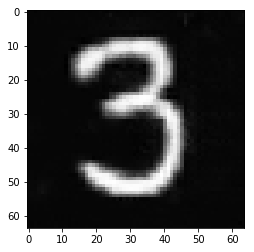

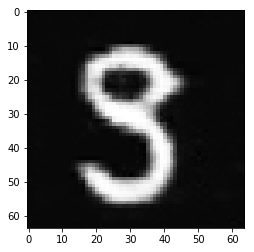

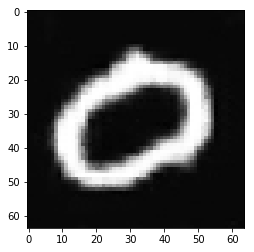

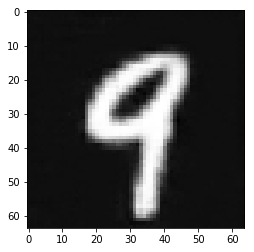

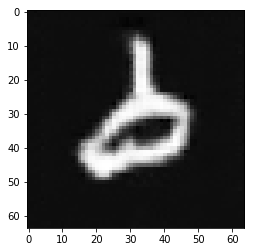

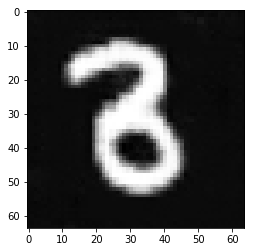

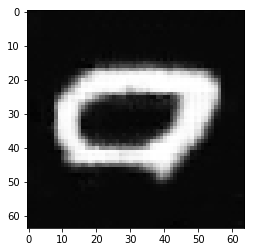

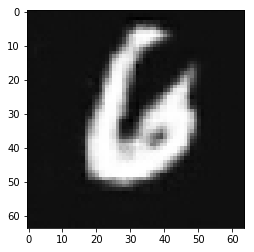

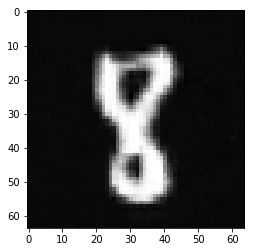

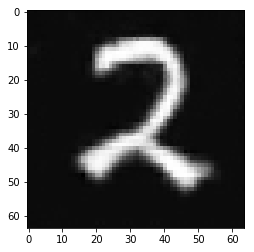

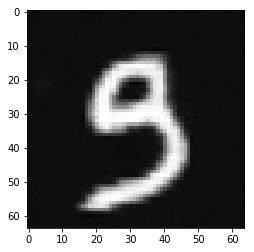

<Figure size 432x288 with 0 Axes>

In [60]:
vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
import random
loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []
import matplotlib.pyplot as plt

mnist_iterator = mnist_ds.make_one_shot_iterator() 
for i in range(500):
    real_images, real_labels = mnist_iterator.get_next() # get a batch from real_ds
    real_labels = np.ones([batch_size,])

    noise = np.random.uniform(-1, 1.0, size=[batch_size, 100])
    fake_images = net_generator.predict(noise) # create fake batch of images
    fake_labels = np.zeros([batch_size,]) # fake images are labeled as 0
    if i % 25 == 0:
        rand_n = random.randint(0,batch_size-1)
        fake_images_plt = np.squeeze(fake_images,axis=3)
        plt.gray()
        plt.imshow(fake_images_plt[rand_n])
        plt.show()
        plt.savefig('gen_img_'+str(i)+'.jpg')

    # Train D
    # Fake data
    model_discriminator.train_on_batch(fake_images, fake_labels)
    # Real Data
    model_discriminator.train_on_batch(real_images, real_labels)
    
#     # Train G
    y = tf.ones((batch_size), dtype='uint8')
    noise = np.random.uniform(-1, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)

[1. 1. 1.]
(64, 64, 1)


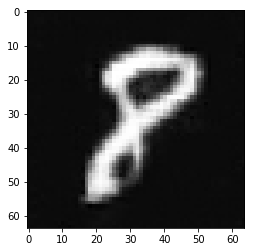

tf.Tensor(
[[0.48848775]
 [0.49196315]
 [0.48545048]
 [0.48935017]
 [0.48939577]
 [0.48768547]
 [0.48795357]
 [0.48637015]
 [0.4890004 ]
 [0.48787814]
 [0.48722005]
 [0.48669302]
 [0.48755443]
 [0.49066055]
 [0.48642907]
 [0.48968104]
 [0.48965433]
 [0.48961654]
 [0.48684552]
 [0.49115396]
 [0.485166  ]
 [0.49103668]
 [0.4884592 ]
 [0.48606676]
 [0.488401  ]
 [0.48765635]
 [0.48956496]
 [0.48782226]
 [0.49133968]
 [0.4876706 ]
 [0.48793298]
 [0.48676112]
 [0.48771915]
 [0.4896574 ]
 [0.4896531 ]
 [0.48724756]
 [0.48849976]
 [0.48835346]
 [0.48815662]
 [0.4870139 ]
 [0.48484093]
 [0.487444  ]
 [0.4903242 ]
 [0.49029583]
 [0.48810792]
 [0.48641375]
 [0.4887071 ]
 [0.49102485]
 [0.48803702]
 [0.48769295]
 [0.48692095]
 [0.4857954 ]
 [0.48999348]
 [0.48929608]
 [0.48823577]
 [0.4894391 ]
 [0.48704633]
 [0.48666126]
 [0.48934612]
 [0.4873189 ]
 [0.48770255]
 [0.4887675 ]
 [0.48870388]
 [0.48844114]], shape=(64, 1), dtype=float32)
tf.Tensor(
[[0.48798835]
 [0.48643047]
 [0.48503608]
 [0.4881

In [58]:
# Debugging stuff

mnist_iterator = mnist_ds.make_one_shot_iterator()
real_images, real_labels = mnist_iterator.get_next()
real_labels = np.ones([batch_size])
print(real_labels[0:3])
predictions = model_discriminator(real_images, training=False)

noise = tf.random.uniform(shape=(batch_size,100,), minval=0, maxval= 1.0)
import matplotlib.pyplot as plt



fake_images = net_generator(noise, training=False)
print(fake_images[0,:,:,:].shape)

predictions2 = model_discriminator(fake_images, training=False)
fake_images = np.squeeze(fake_images,axis=2)
plt.gray()
plt.imshow(fake_images[0])
plt.show()
print(predictions)
print(predictions2)